In [1]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

# Source Image

Calculated PSF from PROPER

In [2]:
from spirals import binarized_ringed_flipped

def binarized_ringed_650(r, phi):
    phase = 650.*1e-9*0.5
    return binarized_ringed_flipped(r, phi, phase)

beam_ratio = 0.4
toliman_settings = {
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 571.7300 / 1000.,
                    'm1_m2_sep': 549.240/1000.,
                    'm2_fl': -23.3800/1000.,
                    'bfl': 590.000 / 1000., 
                    'm2_rad': 5.9 / 1000., 
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'beam_ratio': beam_ratio,
                    'tilt_x': 0.00,
                    'tilt_y': 0.00,
                    'opd_func': binarized_ringed_650,
                    'm1_hole_rad':0.025,
                    'use_caching':True
                    }
gridsize = 2048 # sampling of wavefront
wavelength = 0.65 # micros

def get_source(dx, dy, dI):
    settings = toliman_settings.copy()
    settings['tilt_x'] = dx
    settings['tilt_y'] = dy
    new  = {
            'wavelengths': [wavelength],
            'weights': [dI],
            'settings': settings
            }
    return new

params_a = (-1,-0.5,1.3) # Chosen at random
params_b = (params_a[0],params_a[1]+5.,params_a[2]/3.)

In [3]:
import proper
detector_pitch = 11.0e-6 # m/pixel on detector
npixels = 512 # Size of detector, in pixels

# Calculated PSF
# First source, on axis
# Second source, offset 5" and fainter
from proper_tools import form_detector_image
raw_image = form_detector_image('prescription_rc_quad', [get_source(params_a[0],params_a[1],params_a[2]), get_source(params_b[0],params_b[1],params_b[2])], gridsize, detector_pitch, npixels)

/home/ubuntu/miniconda/envs/astroconda/lib/python3.5/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [4]:
import numpy as np
src_peak_photons = 25000
src_intensity_scale = (src_peak_photons/raw_image.max(axis=None))
raw_image = np.clip(src_intensity_scale*raw_image,0.,None)
detector_image = np.random.poisson(raw_image)

# Fitting

## Create a dual PSF and check fitting error


In [5]:
# Calculated PSF using on-axis image
from proper_tools import form_detector_image, form_multi_psf, fix_prop_pixellate

In [6]:
test_flux = 1.0
#print('Flux based upon observed peak = {}'.format(test_flux))
test_offset = (0.,0.)
#print('Test PSF centred at ({},{})'.format(test_offset[0],test_offset[1]))
      
common_sampling = detector_pitch/2. # for Nyquist
npsf = npixels*2
#print('Generating PSF with sampling {} and size {}'.format(common_sampling,npsf))
psf_ref = form_multi_psf('prescription_rc_quad', [get_source(test_offset[0],test_offset[1],test_flux)], gridsize, common_sampling, npsf)


In [7]:
def image_err(im):
    diff = im - detector_image
    return np.sum((diff)**2)
    
min_err = image_err(raw_image)

In [8]:
f_eff = 15. # metres
as_to_m = f_eff * np.pi / (3600 * 180) #m/as

model = {}
model['x'] = [0.,0.,0.,0.,0.,0.]
model['psf_a_pix'] = np.zeros_like(detector_image)
model['psf_b_pix'] = np.zeros_like(detector_image)

def model_image():
    return (model['psf_a_pix']*model['x'][2] + model['psf_b_pix']*model['x'][5]) * src_intensity_scale

def set_psf_a(im):
    model['psf_a_pix'] = im

def set_pos_a(dx,dy):
    x = model['x']
    x[0] = dx
    x[1] = dy
    set_psf_a(fix_prop_pixellate(psf_ref, common_sampling, detector_pitch, n_out = npixels, offset=(dx*as_to_m,dy*as_to_m)))

def set_psf_b(im):
    model['psf_b_pix'] = im
    
def set_pos_b(dx,dy):
    x = model['x']
    x[3] = dx
    x[4] = dy
    set_psf_b(fix_prop_pixellate(psf_ref, common_sampling, detector_pitch, n_out = npixels, offset=(dx*as_to_m,dy*as_to_m)))

def set_major_flux(f):
    x = model['x']
    x[2] = f

def set_minor_flux(f):
    x = model['x']
    x[5] = f
    
def update_err(printerr=False, logerr=True):
    x = model['x']
    tiltx1 = x[0]
    tilty1 = x[1]    
    flux1 = x[2]
    tiltx2 = x[3]
    tilty2 = x[4]
    flux2 = x[5]
    err = image_err(model_image())
    if logerr is True:
        errors.append((x.copy(),err))
    if printerr is True:
        print('Error for offsets ({:.2e},{:.2e}),({:.2e},{:.2e}) and fluxes {:.2e},{:.2e}: {}% baseline '.format(tiltx1, tiltx1, tiltx2, tiltx2, flux1, flux2, round(100.*err/min_err)))
    return err

def model_err_major_pos(params, printerr=False, logerr=True):
    set_pos_a(params[0],params[1])
    return update_err(printerr, logerr)

def model_err_minor_pos(params, printerr=False, logerr=True):
    set_pos_b(params[0],params[1])
    return update_err(printerr,logerr)

def model_err_major_flux(f, printerr=False, logerr=True):
    set_major_flux(f)
    return update_err(printerr,logerr)

def model_err_minor_flux(f, printerr=False, logerr=True):
    set_minor_flux(f)
    return update_err(printerr,logerr)


In [28]:
def set_model_params(x):
    model['x'] = x.copy()
    set_psf_a(fix_prop_pixellate(psf_ref, common_sampling, detector_pitch, n_out = npixels, offset=(x[0]*as_to_m,x[1]*as_to_m)))
    set_psf_b(fix_prop_pixellate(psf_ref, common_sampling, detector_pitch, n_out = npixels, offset=(x[3]*as_to_m,x[4]*as_to_m)))


In [9]:
print('Minimum error (original - noisy) = {}'.format(min_err))

Minimum error (original - noisy) = 24831181.537229158


# Perform Cross-correlation

In [10]:
#Generate centred test image 
from time import time
t = time()
test_im = fix_prop_pixellate(psf_ref, common_sampling, detector_pitch, n_out = npixels, offset=(0,0))
print(time()-t)

0.27364563941955566


In [11]:
psf_template=np.copy(test_im[256-50:256+50,256-50:256+50])
psf_template -= psf_template.mean()

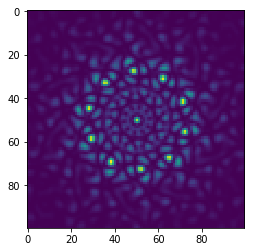

In [12]:
import matplotlib.pyplot as plt
plt.imshow(psf_template)
plt.show()

In [13]:
from scipy import signal
from time import time
t=time()
corr = signal.correlate2d(detector_image, psf_template, boundary='symm', mode='same')
print(time()-t)

8.425424337387085


In [14]:
from skimage.feature import peak_local_max
max_loc = peak_local_max(corr,num_peaks=1)[0]
print(max_loc)

[248 252]


In [15]:
print('Offset in arcsecs:',(max_loc - (256,256))*detector_pitch/as_to_m)

Offset in arcsecs: [-1.21008686 -0.60504343]


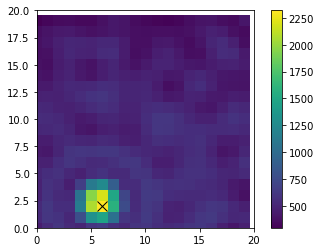

In [16]:
# Zoom in and show peak
import matplotlib.pyplot as plt
hw=10
offset=256-hw
plt.imshow(corr[offset:offset+2*hw,offset:offset+2*hw],interpolation='none')
plt.plot(max_loc[1]-(offset),max_loc[0]-(offset),"kx", markersize=10)
plt.xlim([0, 2*hw])
plt.ylim([0, 2*hw])
plt.colorbar()
plt.show()

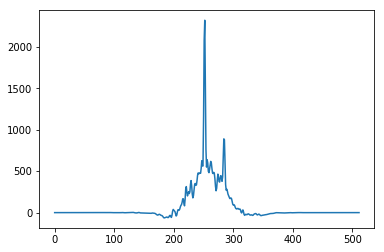

In [17]:
import matplotlib.pyplot as plt
plt.plot(corr[248])
plt.show()

## Fine-tune major source position

In [18]:
est_flux = detector_image.max(axis=None)*1. / src_peak_photons
model_bsf = [(max_loc[0] - 256)*detector_pitch/as_to_m,(max_loc[1] - 256)*detector_pitch/as_to_m,est_flux,0.,0.,0.]
set_model_params(model_bsf)

In [19]:
print(model['x'])

[-1.2100868633162987, -0.60504343165814933, 1.0134399999999999, 0.0, 0.0, 0.0]


How does the landscape look? Here I'm plotting the error function at reaonably high resolution, but ideally an optimiser will not explore this by such brute force means.

In [20]:
import numpy as np
ds = np.linspace(-1., 1., 21)
X,Y  = np.meshgrid(ds+model_bsf[0],ds+model_bsf[1])
Z = np.empty_like(X)
for i in range(len(ds)):
    for j in range(len(ds)):
        Z[i][j] = model_err_major_pos([X[i][j],Y[i][j]], printerr=False,logerr=False)

In [24]:
from skopt import gbrt_minimize
errors=[]
params_init = [(-.5+model_bsf[0],.5+model_bsf[0]),(-.5+model_bsf[1],.5+model_bsf[1])]
res = gbrt_minimize(model_err_major_pos, params_init)

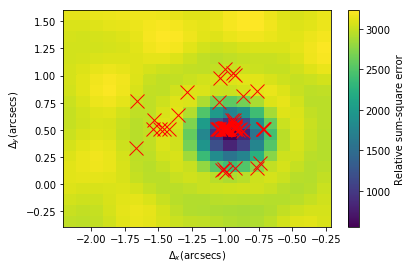

In [25]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cm = ax.pcolormesh(X, -Y, Z / min_err)#,
cb = fig.colorbar(cm)
tested = [(x,y) for ((x,y,_,_,_,_),e) in errors]
ax.plot([x for (x,y) in tested], [-y for (x,y) in tested],"rx", markersize=14, lw=0)
cb.set_label("Relative sum-square error")
ax.set_xlabel("$\Delta_x$(arcsecs)")
ax.set_ylabel("$\Delta_y$(arcsecs)")
plt.show()

How does the optimizer do in finding the minimum?

In [26]:
print(res.x)

[-0.99882776556602559, -0.5071059753334447]


In [27]:
model_bsf[0] = res.x[0]
model_bsf[1] = res.x[1]

In [29]:
set_pos_a(model_bsf[0],model_bsf[1])

##  Step 2: major source flux

In [32]:
from skopt import gp_minimize
errors=[]
res = gp_minimize(model_err_major_flux, [(0.2,2.)])

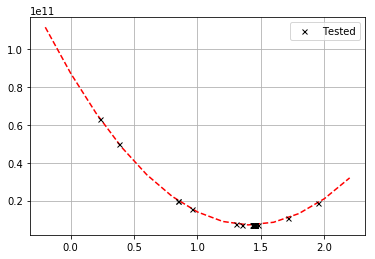

In [33]:
# Plot f(x) + contours
x = np.arange(-0.2, 2.2, .2).reshape(-1, 1)
fx = [model_err_major_flux(x_i,printerr=False, logerr=False) for x_i in x]
plt.plot(x, fx, "r--")
tested = [(v,e) for ((_,_,v,_,_,_),e) in errors]
plt.plot([v for (v,e) in tested], [e for (v,e) in tested],"kx", markersize=5, lw=0, label="Tested")
plt.legend()
plt.grid()
plt.show()

In [34]:
print(res.x)
set_major_flux(res.x[0])
model_bsf[2]=res.x[0]

[1.4330246318348414]


## Step 3: minor source position

In [35]:
residual = detector_image - model_image()

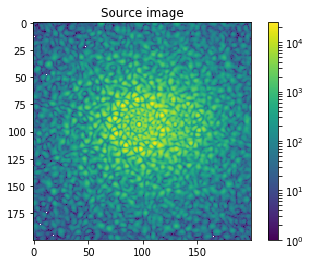

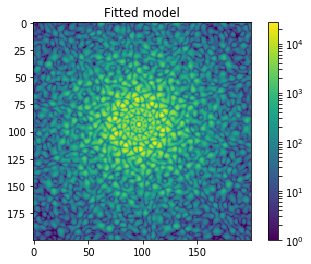

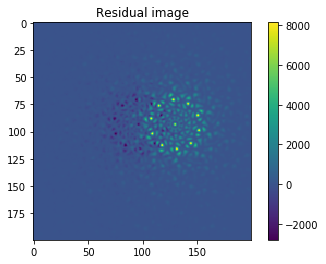

In [36]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.imshow(detector_image[256-100:256+100,256-100:256+100], interpolation = 'none', cmap='viridis',norm=LogNorm(),vmin=1.)
plt.colorbar()
plt.title('Source image')
plt.show()

plt.imshow(model_image()[256-100:256+100,256-100:256+100], interpolation = 'none', cmap='viridis',norm=LogNorm(),vmin=1.)
plt.colorbar()
plt.title('Fitted model')
plt.show()

plt.imshow(residual[256-100:256+100,256-100:256+100], interpolation = 'none', cmap='viridis')
plt.colorbar()
plt.title('Residual image')
plt.show()

In [37]:
est_flux = residual.max(axis=None)*1. / src_peak_photons
print('Flux based upon observed peak = {}'.format(est_flux))
set_minor_flux(est_flux)

Flux based upon observed peak = 0.3254192160068461


In [45]:
model_bsf[5]=est_flux

In [38]:
from scipy import signal
from time import time
t=time()
corr = signal.correlate2d(residual, psf_template, boundary='symm', mode='same')
print(time()-t)

8.246607065200806


In [39]:
from skimage.feature import peak_local_max
max_loc = peak_local_max(corr,num_peaks=1)[0]
print(max_loc)

[248 285]


In [40]:
print('Offset in arcsecs:',(max_loc - (256,256))*detector_pitch/as_to_m)

Offset in arcsecs: [-1.21008686  4.38656488]


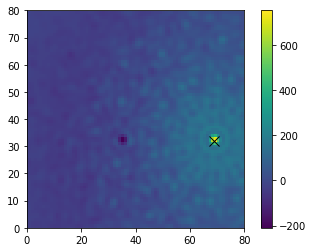

In [43]:
# Zoom in and show peak
import matplotlib.pyplot as plt
hw=40
offset=256-hw
plt.imshow(corr[offset:offset+2*hw,offset:offset+2*hw],interpolation='none')
plt.plot(max_loc[1]-(offset),max_loc[0]-(offset),"kx", markersize=10)
plt.xlim([0, 2*hw])
plt.ylim([0, 2*hw])
plt.colorbar()
plt.show()

In [47]:
model_bsf[3] = (max_loc[0] - 256)*detector_pitch/as_to_m
model_bsf[4] = (max_loc[1] - 256)*detector_pitch/as_to_m

In [48]:
print(model_bsf)

[-0.99882776556602559, -0.5071059753334447, 1.4330246318348414, -1.2100868633162987, 4.3865648795215826, 0.32541921600684609]


In [46]:
print(model['x'])

[-0.99882776556602559, -0.5071059753334447, 1.4330246318348414, -1.1667549727111091, 4.0991189037374021, 0.32541921600684609]


In [49]:
import numpy as np
ds = np.linspace(-1., 1., 21)
X,Y  = np.meshgrid(ds+model_bsf[3],ds+model_bsf[4])
Z = np.empty_like(X)
for i in range(len(ds)):
    for j in range(len(ds)):
        Z[i][j] = model_err_minor_pos([X[i][j],Y[i][j]], printerr=False,logerr=False)

In [50]:
from skopt import gbrt_minimize
errors=[]
params_init = [(-.5+model_bsf[3],.5+model_bsf[3]),(-.5+model_bsf[4],.5+model_bsf[4])]
res = gbrt_minimize(model_err_minor_pos, params_init)

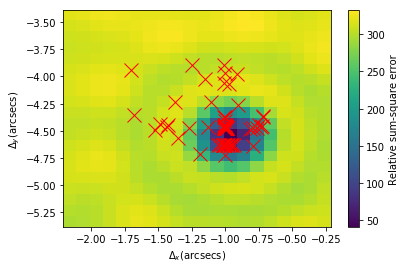

In [52]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cm = ax.pcolormesh(X, -Y, Z / min_err)#,
cb = fig.colorbar(cm)
tested = [(x,y) for ((_,_,_,x,y,_),e) in errors]
ax.plot([x for (x,y) in tested], [-y for (x,y) in tested],"rx", markersize=14, lw=0)
cb.set_label("Relative sum-square error")
ax.set_xlabel("$\Delta_x$(arcsecs)")
ax.set_ylabel("$\Delta_y$(arcsecs)")
plt.show()

How does the optimizer do in finding the minimum?

In [53]:
print(res.x)

[-1.0006333140087571, 4.4775111357330575]


In [56]:
model_bsf[3] = res.x[0]
model_bsf[4] = res.x[1]

In [58]:
set_pos_b(res.x[0],res.x[1])

In [59]:
print(model['x'])

[-0.99882776556602559, -0.5071059753334447, 1.4330246318348414, -1.0006333140087571, 4.4775111357330575, 0.32541921600684609]


# Final tweak

In [60]:
def model_err(params, printerr=False, logerr=True):
    set_pos_a(params[0],params[1])
    set_major_flux(params[2])
    set_pos_b(params[3],params[4])
    set_minor_flux(params[5])
    return update_err(printerr,logerr)

In [63]:
from skopt import gbrt_minimize
errors=[]
params_init = [(-.1+model_bsf[0],.1+model_bsf[0]),(-.1+model_bsf[1],.1+model_bsf[1]),(-.2+model_bsf[2],.2+model_bsf[2]),(-.1+model_bsf[3],.1+model_bsf[3]),(-.1+model_bsf[4],.1+model_bsf[4]),(-.2+model_bsf[5],.2+model_bsf[5])]
res = gbrt_minimize(model_err, params_init, x0=[model_bsf])

In [64]:
print(res.x)

[-0.99850640970376581, -0.50622917974118298, 1.3164950642381277, -1.0074578052809671, 4.492131572431715, 0.44556538000759777]


In [68]:
model_bsf = res.x.copy()

In [65]:
set_model_params(res.x)

In [66]:
residual = detector_image - model_image()

# Summary

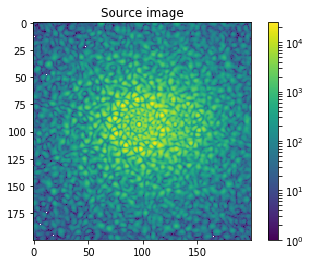

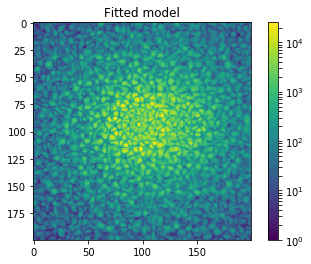

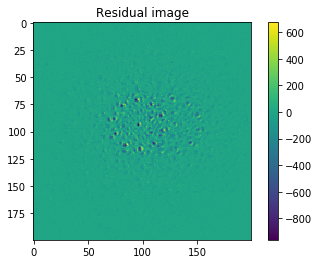

In [67]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.imshow(detector_image[256-100:256+100,256-100:256+100], interpolation = 'none', cmap='viridis',norm=LogNorm(),vmin=1.)
plt.colorbar()
plt.title('Source image')
plt.show()

plt.imshow(model_image()[256-100:256+100,256-100:256+100], interpolation = 'none', cmap='viridis',norm=LogNorm(),vmin=1.)
plt.colorbar()
plt.title('Fitted model')
plt.show()

plt.imshow(residual[256-100:256+100,256-100:256+100], interpolation = 'none', cmap='viridis')
plt.colorbar()
plt.title('Residual image')
plt.show()

In [70]:
print('{:.2e}({:.2e}), {:.2e}({:.2e}), {:.2e}({:.2e}), {:.2e}({:.2e}), {:.2e}({:.2e}), {:.2e}({:.2e}): {}% baseline '.format(model_bsf[0], model_bsf[0] - params_a[0], 
                                                                                                         model_bsf[1], model_bsf[1] - params_a[1],
                                                                                                         model_bsf[2], model_bsf[2] - params_a[2],
                                                                                                         model_bsf[3], model_bsf[3] - params_b[0],
                                                                                                         model_bsf[4], model_bsf[4] - params_b[1], 
                                                                                                         model_bsf[5], model_bsf[5] - params_b[2],
                                                                                                         round(100.*image_err(model_image())/min_err)))

-9.99e-01(1.49e-03), -5.06e-01(-6.23e-03), 1.32e+00(1.65e-02), -1.01e+00(-7.46e-03), 4.49e+00(-7.87e-03), 4.46e-01(1.22e-02): 430.0% baseline 
